# Using a pre-trained model and extracting information about context specific feature impacts using Sampling Perturbation method for Transformers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import torch
import numpy as np
import matplotlib
from torch import nn
from torch.nn import functional as F
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from torch_geometric.loader import DataLoader
from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.model import TransformerGenerator
from scgpt.loss import (
    masked_mse_loss,
    criterion_neg_log_bernoulli,
    masked_relative_error,
)
from scgpt.tokenizer import tokenize_batch, pad_batch, tokenize_and_pad_batch
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed, map_raw_id_to_vocab_id, compute_perturbation_metrics

matplotlib.rcParams["savefig.transparent"] = False
warnings.filterwarnings("ignore")

set_seed(42)


/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## Training Settings

In [3]:
# settings for data prcocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
pad_value = 0  # for padding values
pert_pad_id = 0
include_zero_gene = "all"
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
amp = True
load_model = "../save/scGPT_human"
load_param_prefixs = [
    "encoder",
    "value_encoder",
    "transformer_encoder",
    "transformer_decoder"
]

# settings for optimizer
lr = 1e-4  # or 1e-4
batch_size = 64
eval_batch_size = 64
epochs = 3
schedule_interval = 1
early_stop = 10

# settings for the model
embsize = 512  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
n_layers_cls = 3
dropout = 0  # dropout probability
use_fast_transformer = True  # whether to use fast transformer

# logging
log_interval = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
pert_data = PertData("../data/")
pert_data.load(data_path='../data/fibroblast_fm6_with_fm1_raw/')
pert_data.prepare_split(split='no_split', seed=1)
pert_data.get_dataloader(batch_size=batch_size, test_batch_size=eval_batch_size)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


{'test_loader': <torch_geometric.deprecation.DataLoader at 0x7f155d9741f0>}

In [5]:
data_name = 'testing_sampling_pert'
save_dir = Path(f"./save/dev_perturb_{data_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"saving to {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")
# log running date and current git commit
logger.info(f"Running on {time.strftime('%Y-%m-%d %H:%M:%S')}")

saving to save/dev_perturb_testing_sampling_pert-Nov05-14-02
scGPT - INFO - Running on 2024-11-05 14:02:12


In [6]:
if load_model is not None:
    model_dir = Path(load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    pert_data.adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in pert_data.adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(pert_data.adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    genes = pert_data.adata.var["gene_name"].tolist()

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    genes = pert_data.adata.var["gene_name"].tolist()
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(
    [vocab[gene] if gene in vocab else vocab["<pad>"] for gene in genes], dtype=int
)
n_genes = len(genes)



scGPT - INFO - match 17315/17315 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


 # Create and train scGpt

In [15]:
from scgpt.model import TransformerModel
from scgpt.utils import load_pretrained

In [138]:
ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=n_layers_cls,
    n_cls=1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    use_fast_transformer=use_fast_transformer,
)
# if load_param_prefixs is not None and load_model is not None:
#     # only load params that start with the prefix
#     model_dict = model.state_dict()
#     pretrained_dict = torch.load(model_file,  map_location=torch.device(device))
#     pretrained_dict = {
#         k: v
#         for k, v in pretrained_dict.items()
#         if any([k.startswith(prefix) for prefix in load_param_prefixs])
#     }
#     for k, v in pretrained_dict.items():
#         logger.info(f"Loading params {k} with shape {v.shape}")
#     model_dict.update(pretrained_dict)
#     model.load_state_dict(model_dict)
# elif load_model is not None:
#     try:
#         model.load_state_dict(torch.load(model_file))
#         logger.info(f"Loading all model params from {model_file}")
#     except:
#         # only load params that are in the model and match the size
#         model_dict = model.state_dict()
#         pretrained_dict = torch.load(model_file, map_location=torch.device(device))
#         pretrained_dict = {
#             k: v
#             for k, v in pretrained_dict.items()
#             if k in model_dict and v.shape == model_dict[k].shape
#         }
#         for k, v in pretrained_dict.items():
#             logger.info(f"Loading params {k} with shape {v.shape}")
#         model_dict.update(pretrained_dict)
#         model.load_state_dict(model_dict)

In [139]:
best_model = load_pretrained(model, torch.load(model_file), verbose=True, strict=False)
model.to(device)

scGPT - INFO - Loading parameter encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading parameter encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading parameter encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading parameter value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading parameter value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading parameter value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading parameter value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading parameter value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading parameter value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading parameter transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading parameter transformer_encoder.layers.0.self_attn.Wqk

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=512, out_fe

In [140]:
import torch_geometric
from torch_geometric.data import Data
from typing import List, Union

In [146]:
def generate_binary_array(n_masks, n_genes, fraction):
    """
    Generate a binary 2D NumPy array with a set fraction of 1s randomly distributed in every row.

    Parameters:
    rows (int): Number of rows in the array.
    cols (int): Number of columns in the array.
    fraction (float): Fraction of 1s in each row (0 <= fraction <= 1).

    Returns:
    np.ndarray: Binary 2D NumPy array.
    """
    if not (0 <= fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")

    array = np.zeros((n_masks, n_genes), dtype=int)
    num_ones = int(fraction * n_genes)

    for row in array:
        ones_indices = np.random.choice(n_genes, num_ones, replace=False)
        row[ones_indices] = 1

    return array

def apply_masks(
    values: Union[torch.Tensor, np.ndarray],
    masks: np.ndarray,
    mask_value: int = -1,
    pad_value: int = 0,
    indices_to_keep: List[int] = None
) -> torch.Tensor:
    """
    Apply given masks to the values.

    Args:
        values (array-like): The data to mask, shape (n_features,)
        masks (array-like): An array of masks to apply, shape (n_masks, n_features)
        mask_value (int): The value to mask with, default to -1.
        pad_value (int): The value of padding in the values, will be kept unchanged.
        indices_to_keep (list of int): List of indices that should not be masked.

    Returns:
        torch.Tensor: A tensor of masked data, shape (n_masks, n_features)
    """
    if isinstance(values, torch.Tensor):
        values = values.clone().detach().cpu().numpy()
    else:
        values = values.copy()

    if indices_to_keep is None:
        indices_to_keep = []

    masked_values = []
    for i in range(masks.shape[0]):
        mask = masks[i]
        masked_value = values.copy()
        # Only mask the positions where mask == 1 and values != pad_value
        mask_positions = (mask == 1) & (values != pad_value)
        # Set the indices that should not be masked to False
        mask_positions[indices_to_keep] = False
        masked_value[mask_positions] = mask_value
        masked_values.append(masked_value)

    return torch.from_numpy(np.array(masked_values)).float()

def sample_pert(
    model: nn.Module,
    cell_data: torch_geometric.data.Data,
    masks: np.ndarray,
) -> torch.Tensor:
    """
    Applies multiple masks to a single cell record, reconstructs the missing values using the model,
    and returns the reconstructed cell expressions.

    Args:
        model (nn.Module): The transformer model.
        cell_data (torch_geometric.data.Data): The data of a single cell.
        masks (np.ndarray): An array of masks to apply, shape (n_masks, n_genes).
        device (torch.device): The device to run the computations on.
        map_raw_id_to_vocab_id (Callable): Function to map raw gene IDs to vocab IDs.
        gene_ids (torch.Tensor): Tensor of gene IDs.
        criterion (Callable): Loss function.
        amp (bool): Automatic Mixed Precision flag.
        CLS, CCE, MVC, ECS: Model-specific flags.
        vocab (Dict): Vocabulary mapping.
        pad_token (str): Padding token.
        max_seq_len (int, optional): Maximum sequence length.
        include_zero_gene (str): Inclusion criteria for zero-expression genes.

    Returns:
        torch.Tensor: Reconstructed cell expressions, shape (n_masks, n_genes).
    """
    #initial_state_dict = model.state_dict()
    
    model.eval()
    cell_data.to(device)
    x: torch.Tensor = cell_data.x.reshape(1,-1)  # (n_genes, 2)
    
    ori_gene_values = x[0, :]  # (n_genes,)
    
    target_gene_values = x  # (n_genes,)

    n_masks = masks.shape[0]
    n_genes = target_gene_values.shape[1]

    # Repeat ori_gene_values and pert_flags for each mask
    
    #ori_gene_values = ori_gene_values.unsqueeze(0).repeat(n_masks, 1)  # (n_masks, n_genes)
        
    # Prepare input_gene_ids
    if include_zero_gene in ["all", "batch-wise"]:
        if include_zero_gene == "all":
            input_gene_ids = torch.arange(n_genes, device=device, dtype=torch.long)
        else:
            input_gene_ids = (
                ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]
            )
        # Sample input_gene_id
        if max_seq_len and len(input_gene_ids) > max_seq_len:
            # input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[
            #     :max_seq_len
            # ]
            input_gene_ids = torch.tensor(np.arange(max_seq_len)).to(device)

        
        input_values = ori_gene_values[input_gene_ids]
    
        input_values = apply_masks(
                                        input_values,
                                        masks[:, input_gene_ids.cpu().numpy()],
                                        mask_value=-1,
                                        pad_value=0,
                                    ) 
    
        
        mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
        mapped_input_gene_ids = mapped_input_gene_ids.unsqueeze(0).repeat(n_masks, 1)

        # src_key_padding_mask
        src_key_padding_mask = mapped_input_gene_ids.eq(vocab[pad_token])
    
    
    with torch.cuda.amp.autocast(enabled=amp):
        output_dict = model(
            mapped_input_gene_ids.to(device),
            input_values.to(device),
            src_key_padding_mask=src_key_padding_mask.to(device),
            CLS=CLS,
            CCE=CCE,
            MVC=MVC,
            ECS=ECS,
        )
        output_values = output_dict["mlm_output"]  # (n_masks, n_genes)
        #print(output_dict["mlm_output"].shape)
    # Reset model to initial state
    #model.load_state_dict(initial_state_dict)
    return output_values


### Create the reconstructed reprogramming data

In [25]:
import pandas as pd

In [26]:
OKSM = ['SOX2', 'KLF4', 'POU5F1', 'MYC', 'NANOG']

TFs = pd.read_csv('../../perturb_train/little_data/TF_db.csv', index_col = 0)
TFs = TFs.loc[:,'HGNC symbol'].tolist()

ipsc_genes = pert_data.adata.var.gene_name.tolist()
to_perturb = list(set(ipsc_genes).intersection(set(TFs)))

tf_exp = pert_data.adata[:,pert_data.adata.var.gene_name.isin(to_perturb)].X

a = (tf_exp.shape[0] - (tf_exp==0).sum(axis=0))/tf_exp.shape[0]
threshold = 0.10  # Set your desired threshold here

# Get the indexes where values are above the threshold
to_perturb = np.array(to_perturb)[np.array(a).squeeze() > threshold]
to_perturb = np.array(list(set(list(to_perturb) + OKSM)))

In [27]:
# adata_list = []
# for sample in ['fm6', 'mix', 'pr2', 'nr3', 'nic']:
#     pert_data.load(data_path = f'../data/fibroblast_{sample}_with_fm1_raw')
#     pert_data.adata.obs.loc[pert_data.adata.obs.condition != 'ctrl','cluster'] = sample
#     pert_data.adata.obs.loc[pert_data.adata.obs.condition == 'ctrl','cluster'] = 'fm1'
#     adata_list.append(pert_data.adata)

# pert_data.prepare_split(split='no_split', seed=1)
# pert_data.get_dataloader(batch_size=batch_size, test_batch_size=eval_batch_size,)
# import anndata as ad    
# adata_combined = ad.concat(adata_list, join='outer', axis=0)

# duplicates = adata_combined.obs.index.duplicated(keep='first')

# adata_combined = adata_combined[~duplicates,adata_combined.var.index.isin(to_perturb)].copy()

# adata_combined.write_h5ad('./save/adata_combined.h5ad')

In [77]:
import scanpy as sc
adata_combined = sc.read_h5ad('./save/adata_combined.h5ad')

In [78]:
adata_combined.X = adata_combined.X.toarray()

In [81]:
data_is_raw = True
n_hvg = False
n_bins = 51

In [82]:
from scgpt.preprocess import Preprocessor

In [83]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=1,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X",  # the key in adata.layers to store the binned data
)
r = preprocessor(adata_combined,)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - WARNING - The input data seems to be already log1p transformed. Set `log1p=False` to avoid double log1p transform.
scGPT - INFO - Binning data ...


In [84]:
adata_combined.layers['X']

array([[ 0,  0, 26, ...,  0,  0,  0],
       [ 0,  0, 29, ...,  0,  0,  0],
       [ 0,  0, 44, ...,  0,  0,  0],
       ...,
       [ 0,  0, 12, ...,  0,  0, 26],
       [41,  0, 34, ...,  0,  0, 39],
       [ 0,  0,  0, ...,  0,  0, 39]])

In [85]:
to_perturb = adata_combined.var.index.values.squeeze()

In [86]:
# #train_loader = pert_data.dataloader["train_loader"]
# n_masks = 12500
# batch = 128
# fraction = 0.15
# libs = {}
# for library in ['D0-fm', 'D20-nr', 'P20-nr', 'D8-fm', 'D4-fm', 'P3-nr']:
#     expression = adata_combined[adata_combined.obs.library==library].X[0].toarray()
#     single_cell_ref = torch.tensor(expression)
#     n_genes = single_cell_ref.shape[1]
#     masks = generate_binary_array(n_masks, n_genes, fraction)
    
#     ref_cells = []
#     for i in range(0, masks.shape[0]-batch, batch):
#         res = sample_pert(model, Data(x=single_cell_ref), masks[i:i+batch]).detach().cpu().numpy()
#         ref_cells.append(res)
        
#     ref_cells = np.array(ref_cells).reshape(-1, len(to_perturb))
#     ref_cells = pd.DataFrame(ref_cells, columns = adata_combined.var.index.tolist())
#     libs[library] = ref_cells.mean(axis=0)

### Optimise the number of masks needed

In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [30]:
from IPython.display import clear_output

In [31]:
def analyze_dimension_fluctuations(model, adata, batch=4, fraction=0.3, step_size=64):
    """
    Analyze how the first 10 dimensions fluctuate with increasing mask sizes.

    Parameters:
    - single_cell_pert: numpy array, perturbed cell data
    - model: PyTorch model used to sample perturbations
    - adata: AnnData object containing experimental data
    - batch: int, batch size for sampling perturbations
    - fraction: float, fraction of genes to perturb
    - step_size: int, increment in number of masks for each iteration

    Returns:
    - None
    """
    n_genes = adata.var.shape[0]
    single_cell_pert = adata.X[0].toarray()
    
    
    max_masks = 100000
    mask_sizes = list(range(step_size, max_masks + 1, step_size))

    # Initialize a list to hold dimension values for each mask size
    dimension_values = [[] for _ in range(10)]

    pert = adata[adata.obs.condition != 'ctrl'].X.toarray()

    # Generate the maximum number of masks once
    masks = generate_binary_array(max_masks, n_genes, fraction)

    # Sample perturbed cells using the maximum number of masks
    pert_cells = []
    for i in range(0, masks.shape[0] - batch, batch):
        res_pert = sample_pert(model, Data(x=torch.tensor(single_cell_pert)), masks[i:i + batch]).detach().cpu().numpy()
        pert_cells.append(res_pert)

    # Convert to DataFrame
    pert_cells = np.array(pert_cells).reshape(-1, single_cell_pert.shape[1])
    pert_cells = pd.DataFrame(pert_cells, columns=adata.var.index.tolist())

    # Calculate and store the mean values of the first 10 dimensions for each mask size
    for n_masks in mask_sizes:
        sampled_pert_cells = pert_cells.sample(n=n_masks, replace=False)
        for dim in range(10):
            dimension_values[dim].append(sampled_pert_cells.mean().values[dim])

    # Plot the first 10 dimensions as subplots
    fig, axes = plt.subplots(5, 2, figsize=(15, 20))
    fig.suptitle('First 10 Dimensions vs. Number of Masks')

    for dim in range(10):
        ax = axes[dim // 2, dim % 2]
        ax.plot(mask_sizes, dimension_values[dim], marker='o')
        ax.set_xlabel('Number of Masks')
        ax.set_ylabel(f'Dimension {dim + 1} Value')
        ax.grid()

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

#analyze_dimension_fluctuations(model, adata_combined, batch=128, fraction=0.15, step_size=4096)

### After the mask size is optimised, it is time to run the search for the optimal Fibroblast - iPSCs reprogramming factors!
We start by iterating over 3-gene subsets and measuring correlation with all the available reprogramming pathways.

### Generate perturbed cells

In [87]:
pert_data = PertData("../data/")
pert_data.load(data_path='../data/fibroblast_fm6_with_fm1_raw/')
pert_data.prepare_split(split='no_split', seed=1)
pert_data.get_dataloader(batch_size=batch_size, test_batch_size=eval_batch_size)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


{'test_loader': <torch_geometric.deprecation.DataLoader at 0x7f156adf8be0>}

In [88]:
pert_data.adata.X = pert_data.adata.X.toarray()

In [89]:
preprocessor(pert_data.adata)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - WARNING - The input data seems to be already log1p transformed. Set `log1p=False` to avoid double log1p transform.
scGPT - INFO - Binning data ...


In [90]:
# OKSM = ['SOX2', 'KLF4', 'POU5F1', 'MYC', 'NANOG']

# TFs = pd.read_csv('../../perturb_train/little_data/TF_db.csv', index_col = 0)
# TFs = TFs.loc[:,'HGNC symbol'].tolist()

# ipsc_genes = pert_data.adata.var.gene_name.tolist()
# to_perturb = list(set(ipsc_genes).intersection(set(TFs)))

# tf_exp = pert_data.adata[:,pert_data.adata.var.gene_name.isin(to_perturb)].X

# a = (tf_exp.shape[0] - (tf_exp==0).sum(axis=0))/tf_exp.shape[0]
# threshold = 0.10  # Set your desired threshold here

# # Get the indexes where values are above the threshold
# to_perturb = np.array(to_perturb)[np.array(a).squeeze() > threshold]
# to_perturb = np.array(list(set(list(to_perturb) + OKSM)))

# len(to_perturb)

In [91]:
'SOX2' in to_perturb, 'KLF4' in to_perturb, 'MYC' in to_perturb, 'POU5F1'in to_perturb, 'NANOG' in to_perturb

(True, True, True, True, True)

In [49]:
import random
import math
from tqdm import tqdm

# Fallback implementation of comb for Python versions earlier than 3.8
def comb(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

def generate_random_subset(elements, k):
    return tuple(sorted(random.sample(elements, k)))

def generate_random_subsets(elements, k, count):
    total_possible = comb(len(elements), k)
    if count > total_possible:
        raise ValueError(f"Requested count ({count}) exceeds total possible combinations ({total_possible})")
    
    seen = set()
    subsets = []
    
    while len(subsets) < count:
        subset = generate_random_subset(range(len(elements)), k)
        if subset not in seen:
            seen.add(subset)
            subsets.append(tuple(elements[i] for i in subset))
    
    return subsets

def get_subsets(to_perturb, num_subsets=50_000, seed=42):
    random.seed(seed)  # Set seed for reproducibility
    subset_size = 3
    
    print(f"Generating {num_subsets} random {subset_size}-element subsets from {len(to_perturb)} elements")
    return generate_random_subsets(to_perturb, subset_size, num_subsets)

subsets = get_subsets(to_perturb)

print(f"\nTotal subsets generated: {len(subsets)}")
print("\nFirst 5 subsets:")
for i, subset in enumerate(subsets[:5]):
    print(f"Subset {i+1}: {subset}")

print(f"\nLast 5 subsets:")
for i, subset in enumerate(subsets[-5:]):
    print(f"Subset {len(subsets)-4+i}: {subset}")

Generating 50000 random 3-element subsets from 981 elements

Total subsets generated: 50000

First 5 subsets:
Subset 1: ('BCLAF1', 'HDAC6', 'ZNF540')
Subset 2: ('ETV3', 'NRK', 'ZFP1')
Subset 3: ('SMAD7', 'OGG1', 'ZNF438')
Subset 4: ('DNMT3B', 'ZNF408', 'EIF3C')
Subset 5: ('KAT6A', 'TBX20', 'CEBPD')

Last 5 subsets:
Subset 49996: ('MKX', 'ZNF483', 'ZDHHC11')
Subset 49997: ('MEIS3', 'JMY', 'ARHGAP35')
Subset 49998: ('RFX4', 'DZIP1', 'ZNF790')
Subset 49999: ('ZNF646', 'BCOR', 'ZKSCAN5')
Subset 50000: ('REL', 'SERTAD2', 'DDX3X')


In [50]:
pert_data.prepare_split(split='no_split', seed=1)
pert_data.get_dataloader(batch_size=batch_size, test_batch_size=eval_batch_size,)

Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


{'test_loader': <torch_geometric.deprecation.DataLoader at 0x7f155d36b340>}

In [51]:
# adata_list = []
# for sample in ['d20-nr', 'p20-nr', 'd8-fm', 'd4-fm', 'p3-nr']:
#     pert_data.load(data_path = f'../data/fibroblast_{sample}')
#     adata_list.append(pert_data.adata)

# import anndata as ad    
# adata_combined = ad.concat(adata_list, join='outer', axis=0)

### OKSM 3-element subsets data

In [52]:
from itertools import combinations

# Generate all 3-element subsets
subsets_oksm = list(combinations(OKSM, 4))

best_model = model
res = pd.DataFrame()

In [53]:
len(subsets)

50000

### General Search

In [54]:
def perturb_gene_subset(expression, adata_var_index, model, gene_names_to_perturb, batch=4, n_masks=512, fraction=0.3):
    """
    Perturb a desired subset of genes provided as a list of gene names.

    Parameters:
    - adata: AnnData object containing gene expression data
    - model: PyTorch model used to sample perturbations
    - gene_names_to_perturb: list of strings, names of genes to be perturbed
    - batch: int, batch size for sampling perturbations
    - n_masks: int, number of binary masks to generate for sampling
    - fraction: float, fraction of genes to perturb in each mask

    Returns:
    - ref_cells: DataFrame, reference cell reconstructions
    - pert_cells: DataFrame, perturbed cell reconstructions
    """
    # Extract expression data
    
    expression_pert = expression.copy()
    
    # Find indices of genes to perturb
    gene_indices_to_perturb = [adata_var_index.get_loc(gene) for gene in gene_names_to_perturb]
    
    # Apply overexpression to the selected genes
    expression_pert[:, gene_indices_to_perturb] = expression_pert.max() * 1
    
    # Convert to tensors
    #single_cell_ref = torch.tensor(expression)
    single_cell_pert = torch.tensor(expression_pert)
    
    # Generate binary masks
    n_genes = expression_pert.shape[1]
    masks = generate_binary_array(n_masks, n_genes, fraction)
    
    # Sample reference cells
    # ref_cells = []
    # for i in range(0, masks.shape[0] - batch, batch):
    #     res = sample_pert(model, Data(x=single_cell_ref), masks[i:i + batch]).detach().cpu().numpy()
    #     ref_cells.append(res)
    
    # Sample perturbed cells
    pert_cells = []
    for i in range(0, masks.shape[0] - batch, batch):
        res = sample_pert(model, Data(x=single_cell_pert), masks[i:i + batch]).detach().cpu().numpy()
        pert_cells.append(res)
    
    # Convert results to DataFrames
    # ref_cells = np.array(ref_cells).reshape(-1, n_genes)
    # ref_cells = pd.DataFrame(ref_cells, columns=adata.var.index.tolist())

    pert_cells = np.array(pert_cells).reshape(-1, n_genes)
    pert_cells = pd.DataFrame(pert_cells, columns=adata_combined.var.index.tolist())
    
    return pert_cells

In [56]:
adata_combined.obs.cluster.unique()

['fm1', 'fm6', 'mix', 'pr2', 'nr3', 'nic']
Categories (6, object): ['fm1', 'fm6', 'mix', 'nic', 'nr3', 'pr2']

In [58]:
len(set(adata_combined.X[:,0]))

4490

### Load full dataset

In [124]:
adata_c = sc.read_h5ad('../data/readySeu_hrpi_GOOD.h5ad')

In [125]:
mapa = pd.read_csv('../data/gene_info.csv',index_col=0)
mapa = mapa.set_index('feature_id')

def f(x):
    try: 
        return mapa.loc[x]['feature_name']
    except:
        return -1
        
adata_c.var['names'] = adata_c.var.name.apply(lambda x: f(x))
adata_c = adata_c[:,adata_c.var.names!=-1]

In [126]:
adata_c.var = adata_c.var.set_index('names')

In [127]:
adata_c.X = adata_c.X.toarray()

In [128]:
adata_c = adata_c[:,to_perturb]

In [129]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=1,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X",  # the key in adata.layers to store the binned data
)

In [130]:
preprocessor(adata_c)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Binning data ...


In [131]:
adata_combined = adata_c

In [134]:
adata_combined.X = adata_combined.layers['X']

### Run the empty perturbation-reconstruction

In [153]:
cell_n = 3001
reconstructed_ref = True
iterations = 1  # Number of random sampling iterations
n_masks = 128
batch_size = min(128, n_masks-1)
fraction_masked = 0.0
#t = adata_combined[adata_combined.obs.condition=='ctrl'].copy()
adata_var_index = adata_combined.var.index

In [156]:
libs = {}

for library in ['mix']:# ['fm1', 'fm6', 'mix', 'pr2', 'nr3', 'nic']:
    if reconstructed_ref:
        target = adata_combined[adata_combined.obs.cluster==library].copy()
        ref_cells_fin_list = []
        for i in tqdm(range(100)):
            choice = i #np.random.randint(low=0, high=t.X.shape[0])
            expression = target.X[choice,:]  #.toarray()
            
            single_cell_ref = torch.tensor(expression)
            n_genes = single_cell_ref.reshape(1,-1).shape[1]
            masks = generate_binary_array(n_masks, n_genes, fraction_masked)
            
            ref_cells = []
            for i in range(0, masks.shape[0]-batch_size, batch_size):
                res = sample_pert(model, Data(x=single_cell_ref), masks[i:i+batch_size],).detach().cpu().numpy()
                ref_cells.append(res)
                
            ref_cells = np.array(ref_cells).reshape(-1, len(to_perturb))
            ref_cells = pd.DataFrame(ref_cells, columns = adata_combined.var.index.tolist())
            ref_cells_fin_list.append(ref_cells.mean())
        libs[library] = np.mean(ref_cells_fin_list,axis=0)
    else:
        ref_cells = adata_combined[adata_combined.obs.library==library].X
        libs[library] = ref_cells.mean(axis=0)

100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


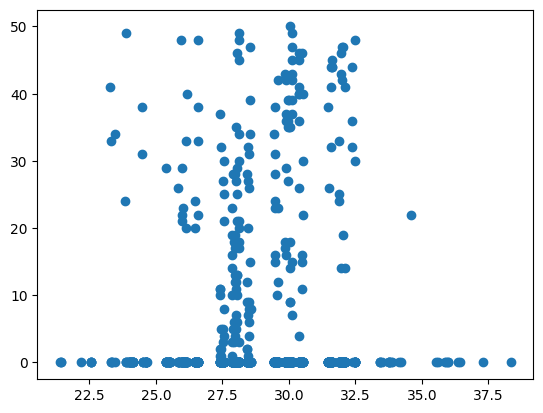

In [157]:
import matplotlib.pyplot as plt
plt.scatter(ref_cells.mean(), expression)

In [32]:
from scipy import stats

res = pd.DataFrame()
counter = 0

for s in tqdm(subsets_oksm+[OKSM]):
    genes = [s]
    name = '_'.join(genes[0])
    for i in range(iterations):        
        expression = t.X[cell_n,:].toarray()
    
        single_cell = perturb_gene_subset(expression, adata_var_index, model, s, batch=batch_size, n_masks=n_masks, fraction=fraction_masked).values
        
        for lib in libs:
            res.loc[f'{name}_{choice}', f'euclid_distance_{lib}'] = np.mean([np.linalg.norm(libs[lib] - single_cell[i]) for i in range(single_cell.shape[0])])
            res.loc[f'{name}_{choice}', f'spearman_corr_{lib}'] = np.mean([stats.spearmanr(libs[lib], single_cell[i])[0] for i in range(single_cell.shape[0])])
        res.to_csv(f'./save/ipsc_perturbation_sampling_search_oksm_1024_masks_RECON_REF_multi_cells_v2_cell_{cell_n}.csv')

100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


In [33]:
res = pd.DataFrame()
choice = cell_n #np.random.randint(low=0, high=t.X.shape[0])
expression = t.X[choice, :].toarray()

# Perturbation Search
if 1 == 1:
    for s in tqdm(subsets):
        genes = [s]
        name = '_'.join(genes[0])
        mean_euclid_distance = {lib: [] for lib in libs}
        mean_pearson_corr = {lib: [] for lib in libs}

        for _ in range(iterations):
            single_cell = perturb_gene_subset(expression, adata_var_index, model, s, batch=batch_size, n_masks=n_masks, fraction=fraction_masked).values
            for lib in libs:
                euclid_distances = [np.linalg.norm(libs[lib] - single_cell[i]) for i in range(single_cell.shape[0])]
                pearson_corrs = [stats.spearmanr(libs[lib], single_cell[i])[0] for i in range(single_cell.shape[0])] #[np.corrcoef(libs[lib], single_cell[i])[0, 1] for i in range(single_cell.shape[0])]
                res.loc[name, f'euclid_distance_{lib}'] = np.mean(euclid_distances)
                res.loc[name, f'spearman_corr_{lib}'] = np.mean(pearson_corrs)

        counter += 1
        clear_output()
        if counter >= 100:
            res.to_csv(f'./save/ipsc_perturbation_sampling_search_1024_masks_RECON_REF_multi_cells_v2_cell_{cell_n}.csv')
            counter = 0

 10%|█         | 5042/50000 [1:29:49<13:20:58,  1.07s/it]

KeyboardInterrupt



#### Real data relationshiops

In [ ]:
corrs = pd.DataFrame(index = libs.keys(), columns = libs.keys())
for lib1 in libs:
    for lib2 in libs:
        pearson_corrs = np.corrcoef(libs[lib1], libs[lib2])[0, 1]
        corrs.loc[lib1,lib2] = pearson_corrs
        

In [ ]:
import seaborn as sns

In [ ]:
order = ['D0-fm','D4-fm','D8-fm','D20-nr','P3-nr','P20-nr']
sns.heatmap(corrs.loc[order, order].astype(float))
plt.savefig('./save/reprog_corr_heatmap.png',bbox_inches='tight')

In [ ]:
libs[lib1].shape